In [4]:
!pip install spotipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 246.2/246.2 KB 4.4 MB/s eta 0:00:0000:01


In [5]:
import numpy as np 
import pandas as pd 
import re
import ast
import json
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
import sys
import requests

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.oauth2 import SpotifyOAuth
import spotipy.util as util

# Content based recommendation for songs as well as artists using Spotify data

## Data Preprocessing

In [6]:
## Read the data
tracks_df = pd.read_csv('../input/spotify-dataset-19212020-600k-tracks/tracks.csv')
tracks_df.head()

id                                 name  popularity  \
0  35iwgR4jXetI318WEWsa1Q                                Carve           6   
1  021ht4sdgPcrDgSk7JTbKY  Capítulo 2.16 - Banquero Anarquista           0   
2  07A5yehtSnoedViJAZkNnc   Vivo para Quererte - Remasterizado           0   
3  08FmqUhxtyLTn6pAh6bk45        El Prisionero - Remasterizado           0   
4  08y9GfoqCWfOGsKdwojr5e                  Lady of the Evening           0   

   duration_ms  explicit              artists                  id_artists  \
0       126903         0              ['Uli']  ['45tIt06XoI0Iio4LBEVpls']   
1        98200         0  ['Fernando Pessoa']  ['14jtPCOoNZwquk5wd9DxrY']   
2       181640         0  ['Ignacio Corsini']  ['5LiOoJbxVSAMkBS2fUm3X2']   
3       176907         0  ['Ignacio Corsini']  ['5LiOoJbxVSAMkBS2fUm3X2']   
4       163080         0      ['Dick Haymes']  ['3BiJGZsyX9sJchTqcSA7Su']   

  release_date  danceability  energy  key  loudness  mode  speechiness  \
0   1922-02-22         0.645  0.4450    0   -13.338     1       0.4510   
1   1922-06-01         0.695  0.2630    0   -22.136     1       0.9570   
2   1922-03-21         0.434  0.1770    1   -21.180     1       0.0512   
3   1922-03-21         0.321  0.0946    7   -27.961     1       0.0504   
4         1922         0.402  0.1580    3   -16.900     0       0.0390   

   acousticness  instrumentalness  liveness  valence    tempo  time_signature  
0         0.674            0.7440     0.151    0.127  104.851               3  
1         0.797            0.0000     0.148    0.655  102.009               1  
2         0.994            0.0218     0.212    0.457  130.418               5  
3         0.995            0.9180     0.104    0.397  169.980               3  
4         0.989            0.1300     0.311    0.196  103.220               4

In [7]:
## convert data in artists column to a list, currently it is string
tracks_df['artists_cleaned'] = tracks_df['artists'].apply(ast.literal_eval)
tracks_df['artists_cleaned'].head(1000)

0                                                 [Uli]
1                                     [Fernando Pessoa]
2                                     [Ignacio Corsini]
3                                     [Ignacio Corsini]
4                                         [Dick Haymes]
                             ...                       
995    [Radclyffe Hall, Alice White, Synthesized Voice]
996                                  [Francisco Canaro]
997    [Radclyffe Hall, Alice White, Synthesized Voice]
998    [Radclyffe Hall, Alice White, Synthesized Voice]
999                          [Lionel Hampton Orchestra]
Name: artists_cleaned, Length: 1000, dtype: object

In [8]:
## id does not uniquely identify songs
print(tracks_df['id'].nunique())
print(tracks_df['name'].nunique())

##Create own key called "artists_song" which is a concatenation of artist name and song
tracks_df['artists_song'] = tracks_df.apply(lambda row: str(row['artists_cleaned'][0])+str(row['name']), axis = 1)
tracks_df.head()

586672
446474


id                                 name  popularity  \
0  35iwgR4jXetI318WEWsa1Q                                Carve           6   
1  021ht4sdgPcrDgSk7JTbKY  Capítulo 2.16 - Banquero Anarquista           0   
2  07A5yehtSnoedViJAZkNnc   Vivo para Quererte - Remasterizado           0   
3  08FmqUhxtyLTn6pAh6bk45        El Prisionero - Remasterizado           0   
4  08y9GfoqCWfOGsKdwojr5e                  Lady of the Evening           0   

   duration_ms  explicit              artists                  id_artists  \
0       126903         0              ['Uli']  ['45tIt06XoI0Iio4LBEVpls']   
1        98200         0  ['Fernando Pessoa']  ['14jtPCOoNZwquk5wd9DxrY']   
2       181640         0  ['Ignacio Corsini']  ['5LiOoJbxVSAMkBS2fUm3X2']   
3       176907         0  ['Ignacio Corsini']  ['5LiOoJbxVSAMkBS2fUm3X2']   
4       163080         0      ['Dick Haymes']  ['3BiJGZsyX9sJchTqcSA7Su']   

  release_date  danceability  energy  ...  mode  speechiness  acousticness  \
0   1922-02-22         0.645  0.4450  ...     1       0.4510         0.674   
1   1922-06-01         0.695  0.2630  ...     1       0.9570         0.797   
2   1922-03-21         0.434  0.1770  ...     1       0.0512         0.994   
3   1922-03-21         0.321  0.0946  ...     1       0.0504         0.995   
4         1922         0.402  0.1580  ...     0       0.0390         0.989   

   instrumentalness  liveness  valence    tempo  time_signature  \
0            0.7440     0.151    0.127  104.851               3   
1            0.0000     0.148    0.655  102.009               1   
2            0.0218     0.212    0.457  130.418               5   
3            0.9180     0.104    0.397  169.980               3   
4            0.1300     0.311    0.196  103.220               4   

     artists_cleaned                                       artists_song  
0              [Uli]                                           UliCarve  
1  [Fernando Pessoa]  Fernando PessoaCapítulo 2.16 - Banquero Anarqu...  
2  [Ignacio Corsini]  Ignacio CorsiniVivo para Quererte - Remasterizado  
3  [Ignacio Corsini]       Ignacio CorsiniEl Prisionero - Remasterizado  
4      [Dick Haymes]                     Dick HaymesLady of the Evening  

[5 rows x 22 columns]

In [10]:
## Check for records with no value in artists or name 
print(tracks_df[tracks_df['artists'].apply(lambda x: len(x) == 0)])
print(tracks_df[tracks_df['name'].apply(lambda x: len(str(x)) == 0)])

##No such records exist

Empty DataFrame
Columns: [id, name, popularity, duration_ms, explicit, artists, id_artists, release_date, danceability, energy, key, loudness, mode, speechiness, acousticness, instrumentalness, liveness, valence, tempo, time_signature, artists_cleaned, artists_song]
Index: []

[0 rows x 22 columns]
Empty DataFrame
Columns: [id, name, popularity, duration_ms, explicit, artists, id_artists, release_date, danceability, energy, key, loudness, mode, speechiness, acousticness, instrumentalness, liveness, valence, tempo, time_signature, artists_cleaned, artists_song]
Index: []

[0 rows x 22 columns]


In [11]:
### multiple records present for same artists_song
tracks_df.groupby('artists_song')['artists_song'].count().sort_values(ascending=False)

artists_song
nan                                       71
BustedYear 3000                           54
Justin BieberHold On                      47
Justin BieberAnyone                       44
J BalvinNo Es Justo                       42
                                          ..
Guidman CamposecoUsame                     1
Guided By VoicesYou're Not An Airplane     1
Guided By VoicesIf We Wait                 1
Guided By VoicesI Am A Scientist           1
최진희사랑의 미로                                  1
Name: artists_song, Length: 523466, dtype: int64

In [13]:
### drop duplicates on artists_song
print(tracks_df.count())
tracks_df.drop_duplicates('artists_song',inplace = True)
print(tracks_df.count())

id                  586672
name                586601
popularity          586672
duration_ms         586672
explicit            586672
artists             586672
id_artists          586672
release_date        586672
danceability        586672
energy              586672
key                 586672
loudness            586672
mode                586672
speechiness         586672
acousticness        586672
instrumentalness    586672
liveness            586672
valence             586672
tempo               586672
time_signature      586672
artists_cleaned     586672
artists_song        586672
dtype: int64
id                  523466
name                523465
popularity          523466
duration_ms         523466
explicit            523466
artists             523466
id_artists          523466
release_date        523466
danceability        523466
energy              523466
key                 523466
loudness            523466
mode                523466
speechiness         523466
acousticness   

In [14]:
######## Now read the artists dataframe
artists_df = pd.read_csv('../input/spotify-dataset-19212020-600k-tracks/artists.csv')
artists_df.head()

id  followers genres  \
0  0DheY5irMjBUeLybbCUEZ2        0.0     []   
1  0DlhY15l3wsrnlfGio2bjU        5.0     []   
2  0DmRESX2JknGPQyO15yxg7        0.0     []   
3  0DmhnbHjm1qw6NCYPeZNgJ        0.0     []   
4  0Dn11fWM7vHQ3rinvWEl4E        2.0     []   

                                             name  popularity  
0  Armid & Amir Zare Pashai feat. Sara Rouzbehani           0  
1                                     ปูนา ภาวิณี           0  
2                                           Sadaa           0  
3                                       Tra'gruda           0  
4                          Ioannis Panoutsopoulos           0

In [15]:
artists_df['genres'].nunique()

49155

In [16]:
## convert data in genres column to a list, currently it is string that looks like lists
artists_df['genres_cleaned'] = artists_df['genres'].apply(ast.literal_eval)
artists_df['genres_cleaned'].head(1000)

0                                                []
1                                                []
2                                                []
3                                                []
4                                                []
                           ...                     
995                                              []
996                                              []
997                                     [austropop]
998                              [audiophile vocal]
999    [croatian pop, croatian rock, yugoslav rock]
Name: genres_cleaned, Length: 1000, dtype: object

In [17]:
artists_df['genres'].nunique()

49155

## Feature Engineering

In [18]:
## One hot encoding of Popularity column
tracks_df['popularity'].describe()

count    523466.000000
mean         27.519061
std          18.306514
min           0.000000
25%          13.000000
50%          27.000000
75%          40.000000
max         100.000000
Name: popularity, dtype: float64

In [21]:
# create 5 point buckets for popularity by dividing by 20
tracks_df['popularity_red'] = tracks_df['popularity'].apply(lambda x: int(x/20))

# create column for year
tracks_df['year'] = tracks_df['release_date'].apply(lambda x: x.split('-')[0])

tracks_df.head()

id                                 name  popularity  \
0  35iwgR4jXetI318WEWsa1Q                                Carve           6   
1  021ht4sdgPcrDgSk7JTbKY  Capítulo 2.16 - Banquero Anarquista           0   
2  07A5yehtSnoedViJAZkNnc   Vivo para Quererte - Remasterizado           0   
3  08FmqUhxtyLTn6pAh6bk45        El Prisionero - Remasterizado           0   
4  08y9GfoqCWfOGsKdwojr5e                  Lady of the Evening           0   

   duration_ms  explicit              artists                  id_artists  \
0       126903         0              ['Uli']  ['45tIt06XoI0Iio4LBEVpls']   
1        98200         0  ['Fernando Pessoa']  ['14jtPCOoNZwquk5wd9DxrY']   
2       181640         0  ['Ignacio Corsini']  ['5LiOoJbxVSAMkBS2fUm3X2']   
3       176907         0  ['Ignacio Corsini']  ['5LiOoJbxVSAMkBS2fUm3X2']   
4       163080         0      ['Dick Haymes']  ['3BiJGZsyX9sJchTqcSA7Su']   

  release_date  danceability  energy  ...  acousticness  instrumentalness  \
0   1922-02-22         0.645  0.4450  ...         0.674            0.7440   
1   1922-06-01         0.695  0.2630  ...         0.797            0.0000   
2   1922-03-21         0.434  0.1770  ...         0.994            0.0218   
3   1922-03-21         0.321  0.0946  ...         0.995            0.9180   
4         1922         0.402  0.1580  ...         0.989            0.1300   

   liveness  valence    tempo  time_signature    artists_cleaned  \
0     0.151    0.127  104.851               3              [Uli]   
1     0.148    0.655  102.009               1  [Fernando Pessoa]   
2     0.212    0.457  130.418               5  [Ignacio Corsini]   
3     0.104    0.397  169.980               3  [Ignacio Corsini]   
4     0.311    0.196  103.220               4      [Dick Haymes]   

                                        artists_song  popularity_red  year  
0                                           UliCarve               0  1922  
1  Fernando PessoaCapítulo 2.16 - Banquero Anarqu...               0  1922  
2  Ignacio CorsiniVivo para Quererte - Remasterizado               0  1922  
3       Ignacio CorsiniEl Prisionero - Remasterizado               0  1922  
4                     Dick HaymesLady of the Evening               0  1922  

[5 rows x 24 columns]

In [23]:
#simple function to create one hot encoding features
def ohe_prep(df, column, new_name): 
    """ 
    Create One Hot Encoded features of a specific column

    Parameters: 
        df (pandas dataframe): Spotify Dataframe
        column (str): Column to be processed
        new_name (str): new column name to be used
        
    Returns: 
        tf_df: One hot encoded features 
    """
    
    tf_df = pd.get_dummies(df[column])
    feature_names = tf_df.columns
    tf_df.columns = [new_name + "|" + str(i) for i in feature_names]
    tf_df.reset_index(drop = True, inplace = True)    
    return tf_df

In [24]:
## create dataframes with one hot encoding for year and popularity
year_ohe = ohe_prep(tracks_df, 'year','year') * 0.5
popularity_ohe = ohe_prep(tracks_df, 'popularity_red','popularity') * 0.15

In [25]:
## normalize float variables
float_cols = tracks_df.dtypes[tracks_df.dtypes == 'float64'].index.values
floats = tracks_df[float_cols].reset_index(drop = True)
scaler = MinMaxScaler()
floats_scaled = pd.DataFrame(scaler.fit_transform(floats), columns = floats.columns) * 0.2
floats_scaled

danceability   energy  loudness  speechiness  acousticness  \
0           0.130172  0.08900  0.142750     0.092894      0.135341   
1           0.140262  0.05260  0.115835     0.197116      0.160040   
2           0.087588  0.03540  0.118759     0.010546      0.199598   
3           0.064783  0.01892  0.098015     0.010381      0.199799   
4           0.081130  0.03160  0.131853     0.008033      0.198594   
...              ...      ...       ...          ...           ...   
523461      0.126337  0.10600  0.143426     0.005850      0.022691   
523462      0.113017  0.10360  0.160698     0.006014      0.157631   
523463      0.154390  0.13260  0.167575     0.013429      0.028313   
523464      0.107972  0.06280  0.144325     0.008404      0.179719   
523465      0.140464  0.12300  0.164550     0.007106      0.041365   

        instrumentalness  liveness  valence     tempo  
0           1.488000e-01   0.03020  0.02540  0.085113  
1           0.000000e+00   0.02960  0.13100  0.082806  
2           4.360000e-03   0.04240  0.09140  0.105867  
3           1.836000e-01   0.02080  0.07940  0.137981  
4           2.600000e-02   0.06220  0.03920  0.083789  
...                  ...       ...      ...       ...  
523461      1.712000e-01   0.02080  0.04300  0.097502  
523462      0.000000e+00   0.01296  0.04220  0.107067  
523463      5.940000e-05   0.01848  0.13720  0.121837  
523464      3.000000e-05   0.01748  0.01326  0.117781  
523465      5.060000e-07   0.06100  0.08760  0.073081  

[523466 rows x 9 columns]

In [26]:
## concatenate features df
final = pd.concat([floats_scaled, popularity_ohe, year_ohe], axis = 1)

#add song id
final['id']=tracks_df['id'].values
final

danceability   energy  loudness  speechiness  acousticness  \
0           0.130172  0.08900  0.142750     0.092894      0.135341   
1           0.140262  0.05260  0.115835     0.197116      0.160040   
2           0.087588  0.03540  0.118759     0.010546      0.199598   
3           0.064783  0.01892  0.098015     0.010381      0.199799   
4           0.081130  0.03160  0.131853     0.008033      0.198594   
...              ...      ...       ...          ...           ...   
523461      0.126337  0.10600  0.143426     0.005850      0.022691   
523462      0.113017  0.10360  0.160698     0.006014      0.157631   
523463      0.154390  0.13260  0.167575     0.013429      0.028313   
523464      0.107972  0.06280  0.144325     0.008404      0.179719   
523465      0.140464  0.12300  0.164550     0.007106      0.041365   

        instrumentalness  liveness  valence     tempo  popularity|0  ...  \
0           1.488000e-01   0.03020  0.02540  0.085113          0.15  ...   
1           0.000000e+00   0.02960  0.13100  0.082806          0.15  ...   
2           4.360000e-03   0.04240  0.09140  0.105867          0.15  ...   
3           1.836000e-01   0.02080  0.07940  0.137981          0.15  ...   
4           2.600000e-02   0.06220  0.03920  0.083789          0.15  ...   
...                  ...       ...      ...       ...           ...  ...   
523461      1.712000e-01   0.02080  0.04300  0.097502          0.15  ...   
523462      0.000000e+00   0.01296  0.04220  0.107067          0.00  ...   
523463      5.940000e-05   0.01848  0.13720  0.121837          0.00  ...   
523464      3.000000e-05   0.01748  0.01326  0.117781          0.00  ...   
523465      5.060000e-07   0.06100  0.08760  0.073081          0.00  ...   

        year|2013  year|2014  year|2015  year|2016  year|2017  year|2018  \
0             0.0        0.0        0.0        0.0        0.0        0.0   
1             0.0        0.0        0.0        0.0        0.0        0.0   
2             0.0        0.0        0.0        0.0        0.0        0.0   
3             0.0        0.0        0.0        0.0        0.0        0.0   
4             0.0        0.0        0.0        0.0        0.0        0.0   
...           ...        ...        ...        ...        ...        ...   
523461        0.0        0.0        0.0        0.0        0.0        0.0   
523462        0.0        0.0        0.0        0.0        0.0        0.0   
523463        0.0        0.0        0.0        0.0        0.0        0.0   
523464        0.0        0.0        0.0        0.0        0.0        0.0   
523465        0.0        0.0        0.0        0.0        0.0        0.0   

        year|2019  year|2020  year|2021                      id  
0             0.0        0.0        0.0  35iwgR4jXetI318WEWsa1Q  
1             0.0        0.0        0.0  021ht4sdgPcrDgSk7JTbKY  
2             0.0        0.0        0.0  07A5yehtSnoedViJAZkNnc  
3             0.0        0.0        0.0  08FmqUhxtyLTn6pAh6bk45  
4             0.0        0.0        0.0  08y9GfoqCWfOGsKdwojr5e  
...           ...        ...        ...                     ...  
523461        0.0        0.5        0.0  1ZwZsVZUiyFwIHMNpI3ERt  
523462        0.0        0.5        0.0  5rgu12WBIHQtvej2MdHSH0  
523463        0.0        0.5        0.0  0NuWgxEp51CutD2pJoF4OM  
523464        0.0        0.5        0.0  27Y1N4Q4U3EfDU5Ubw8ws2  
523465        0.0        0.0        0.5  45XJsGpFTyzbzeWK8VzR8S  

[523466 rows x 117 columns]

## Connect to Spotify API

In [36]:
client_id = '6e98b9f984bc4aa09855674bb31f0f2c'
client_secret= '73f2ff8e8d194bfeb82fefe6e6096b79'
username = '31zx3sydktgrcnruea6vpm5yzsie'
scope = 'user-library-read'

client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret) 
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [37]:
### https://developer.spotify.com/console/get-current-user-playlists/?limit=&offset=

token = "BQBHv-QsHINBqduZqBIBpop_gyDNl3mqmfFgHz8hRCXFRXqnn2H4oitCWWbDFGsCQniscOnWFD75NAzOwEeXbDqAMg1-UXsK7Jg71IEmm2gENyYw-_hZTii5q28QtpkaSsQnJ__9bSYsjUrOC0jH09GI9kVeQxrGTOLYcwymrJIzUky81DZH78OLs0we6SIso8ZYVl_DIvPu9pa7zdCx9pIk0TcKGi4"

In [38]:
sp = spotipy.Spotify(auth=token)

In [39]:
###https://developer.spotify.com/console/get-current-user-playlists/?limit=1000&offset=50

#gather playlist names and images. 
#images aren't going to be used until I start building a UI
id_name = {}
list_photo = {}
for i in sp.current_user_playlists()['items']:

    id_name[i['name']] = i['uri'].split(':')[2]
    list_photo[i['uri'].split(':')[2]] = i['images'][0]['url']

In [42]:
def create_necessary_outputs(playlist_name,id_dic, df):
    """ 
    Pull songs from a specific playlist.

    Parameters: 
        playlist_name (str): name of the playlist you'd like to pull from the spotify API
        id_dic (dic): dictionary that maps playlist_name to playlist_id
        df (pandas dataframe): spotify dataframe
        
    Returns: 
        playlist: all songs in the playlist THAT ARE AVAILABLE IN THE KAGGLE DATASET
    """
    
    #generate playlist dataframe
    playlist = pd.DataFrame()
    playlist_name = playlist_name

    for ix, i in enumerate(sp.playlist(id_dic[playlist_name])['tracks']['items']):
        #print(i['track']['artists'][0]['name'])
        playlist.loc[ix, 'artist'] = i['track']['artists'][0]['name']
        playlist.loc[ix, 'name'] = i['track']['name']
        playlist.loc[ix, 'id'] = i['track']['id'] # ['uri'].split(':')[2]
        playlist.loc[ix, 'url'] = i['track']['album']['images'][1]['url']
        playlist.loc[ix, 'date_added'] = i['added_at']

    playlist['date_added'] = pd.to_datetime(playlist['date_added'])  
    
    playlist = playlist[playlist['id'].isin(df['id'].values)].sort_values('date_added',ascending = False)
    
    return playlist

In [43]:
id_name

{'GetReadyWithesh 09.24.22': '3L0Ze2xMcCx2I4NMr5oeZq',
 'Tay tay': '13qOPfO7MQjVI4yMxlOL5B',
 's*x playlist': '1YF8BgQ3N0jKZM73rOq7li',
 'werkout': '0QSoTzRIajfAHSqPuDZoyQ',
 'Chill Mix': '37i9dQZF1EVHGWrwldPRtj',
 'Daily Mix 3': '37i9dQZF1E39t4S3ZJXiLw',
 '2000s Mix': '37i9dQZF1EQn4jwNIohw50',
 'sad girl starter pack': '37i9dQZF1DWW2hj3ZtMbuO',
 'Calm Labor & Delivery': '37i9dQZF1DXe13FP72mxNn',
 'sad and angry women': '4U3hlCLNBDrrrpeybxZGlo',
 'fiona apple/phoebe bridgers/mitski': '7yshuKyQd4ifs2cJPNY2wz',
 "fiona apple was right: I'm no good at math": '2cjZw6bmlgBj1G2yMjDyS9',
 'Alain de Botton | Podcasts (The School of Life)': '1eczQkI2fhyoanFFYZ7WqL',
 'House Of The Rising Sun': '3K1b6QaX9n30BEQMkXYfXT',
 'glass animals but only bangers': '3T8hciwfThTZaq1xGKYiUJ',
 'All The World (I Tell Myself)': '77onI1bcfAS0GvuYh7SfpZ',
 ';)': '5lD910tffCL9RycxZnjCc7',
 'HYPE PLAYLIST': '7kZbaxh73ty3NzlqwqWuTC',
 'Birthday playlist 2022': '3L62eqt6IJvFGLxqbVDsmp',
 'Energy Booster: Indie': '37

In [49]:
playlist_Chill_Mix = create_necessary_outputs('Top Hits of 2013', id_name, tracks_df)
playlist_Chill_Mix.head()

artist                          name  \
50                  P!nk  True Love (feat. Lily Allen)   
27              Paramore                  Ain't It Fun   
64  Florida Georgia Line                        Cruise   
72        Klangkarussell  Sonnentanz - Sun Don't Shine   
71              Maroon 5                      Daylight   

                        id                                                url  \
50  1QNqrsNQ1JVLEwncov3lEY  https://i.scdn.co/image/ab67616d00001e029d0f0d...   
27  1j8z4TTjJ1YOdoFEDwJTQa  https://i.scdn.co/image/ab67616d00001e02e71a50...   
64  5BhsEd82G0Mnim0IUH6xkT  https://i.scdn.co/image/ab67616d00001e026e89de...   
72  6Qi0Wls2EaolwPMPMxfe5f  https://i.scdn.co/image/ab67616d00001e02e37608...   
71  1NNAI51EuoRWw1ydX1zV7S  https://i.scdn.co/image/ab67616d00001e02fc8633...   

                  date_added  
50 2021-10-19 11:58:27+00:00  
27 2020-06-25 07:35:22+00:00  
64 2020-06-12 06:35:58+00:00  
72 2020-06-12 06:35:58+00:00  
71 2020-06-12 06:35:58+00:00

In [64]:
from skimage import io
import matplotlib.pyplot as plt
from pylab import rcParams

def visualize_songs(df):
    """ 
    Visualize cover art of the songs in the inputted dataframe

    Parameters: 
        df (pandas dataframe): Playlist Dataframe
    """
    
    temp = df['url'].values
    plt.figure(figsize=(15,int(0.625 * len(temp))))
    columns = 5
    
    for i, url in enumerate(temp):
        plt.subplot(int(np.ceil(len(temp) / columns + 1)), columns, i + 1)

        image = io.imread(url)
        plt.imshow(image)
        plt.xticks(color = 'w', fontsize = 0.1)
        plt.yticks(color = 'w', fontsize = 0.1)
        plt.xlabel(df['name'].values[i], fontsize = 12)
        plt.tight_layout(h_pad=0.4, w_pad=0)
        plt.subplots_adjust(wspace=None, hspace=None)

    plt.show()

In [65]:
playlist_Chill_Mix

artist                          name  \
50                  P!nk  True Love (feat. Lily Allen)   
27              Paramore                  Ain't It Fun   
64  Florida Georgia Line                        Cruise   
72        Klangkarussell  Sonnentanz - Sun Don't Shine   
71              Maroon 5                      Daylight   
..                   ...                           ...   
32         One Direction                Best Song Ever   
31                  Zedd                       Clarity   
30       Bridgit Mendler                  Ready or Not   
28     Justin Timberlake      Suit & Tie (feat. Jay-Z)   
98                Baauer                  Harlem Shake   

                        id                                                url  \
50  1QNqrsNQ1JVLEwncov3lEY  https://i.scdn.co/image/ab67616d00001e029d0f0d...   
27  1j8z4TTjJ1YOdoFEDwJTQa  https://i.scdn.co/image/ab67616d00001e02e71a50...   
64  5BhsEd82G0Mnim0IUH6xkT  https://i.scdn.co/image/ab67616d00001e026e89de...   
72  6Qi0Wls2EaolwPMPMxfe5f  https://i.scdn.co/image/ab67616d00001e02e37608...   
71  1NNAI51EuoRWw1ydX1zV7S  https://i.scdn.co/image/ab67616d00001e02fc8633...   
..                     ...                                                ...   
32  5T7ZFtCcOgkpjxcuaeZbw0  https://i.scdn.co/image/ab67616d00001e022f76b7...   
31  60wwxj6Dd9NJlirf84wr2c  https://i.scdn.co/image/ab67616d00001e02941dd3...   
30  5xvUgoVED1F4mBu8FL0HaW  https://i.scdn.co/image/ab67616d00001e02c0758d...   
28  6vt0I1cw1YmAIKDJvHVIM5  https://i.scdn.co/image/ab67616d00001e02db1d1c...   
98  01XFgRZfZI7oBagNf1Loml  https://i.scdn.co/image/ab67616d00001e02bce7a0...   

                  date_added  
50 2021-10-19 11:58:27+00:00  
27 2020-06-25 07:35:22+00:00  
64 2020-06-12 06:35:58+00:00  
72 2020-06-12 06:35:58+00:00  
71 2020-06-12 06:35:58+00:00  
..                       ...  
32 2020-06-12 06:35:58+00:00  
31 2020-06-12 06:35:58+00:00  
30 2020-06-12 06:35:58+00:00  
28 2020-06-12 06:35:58+00:00  
98 2020-06-12 06:35:58+00:00  

[86 rows x 5 columns]

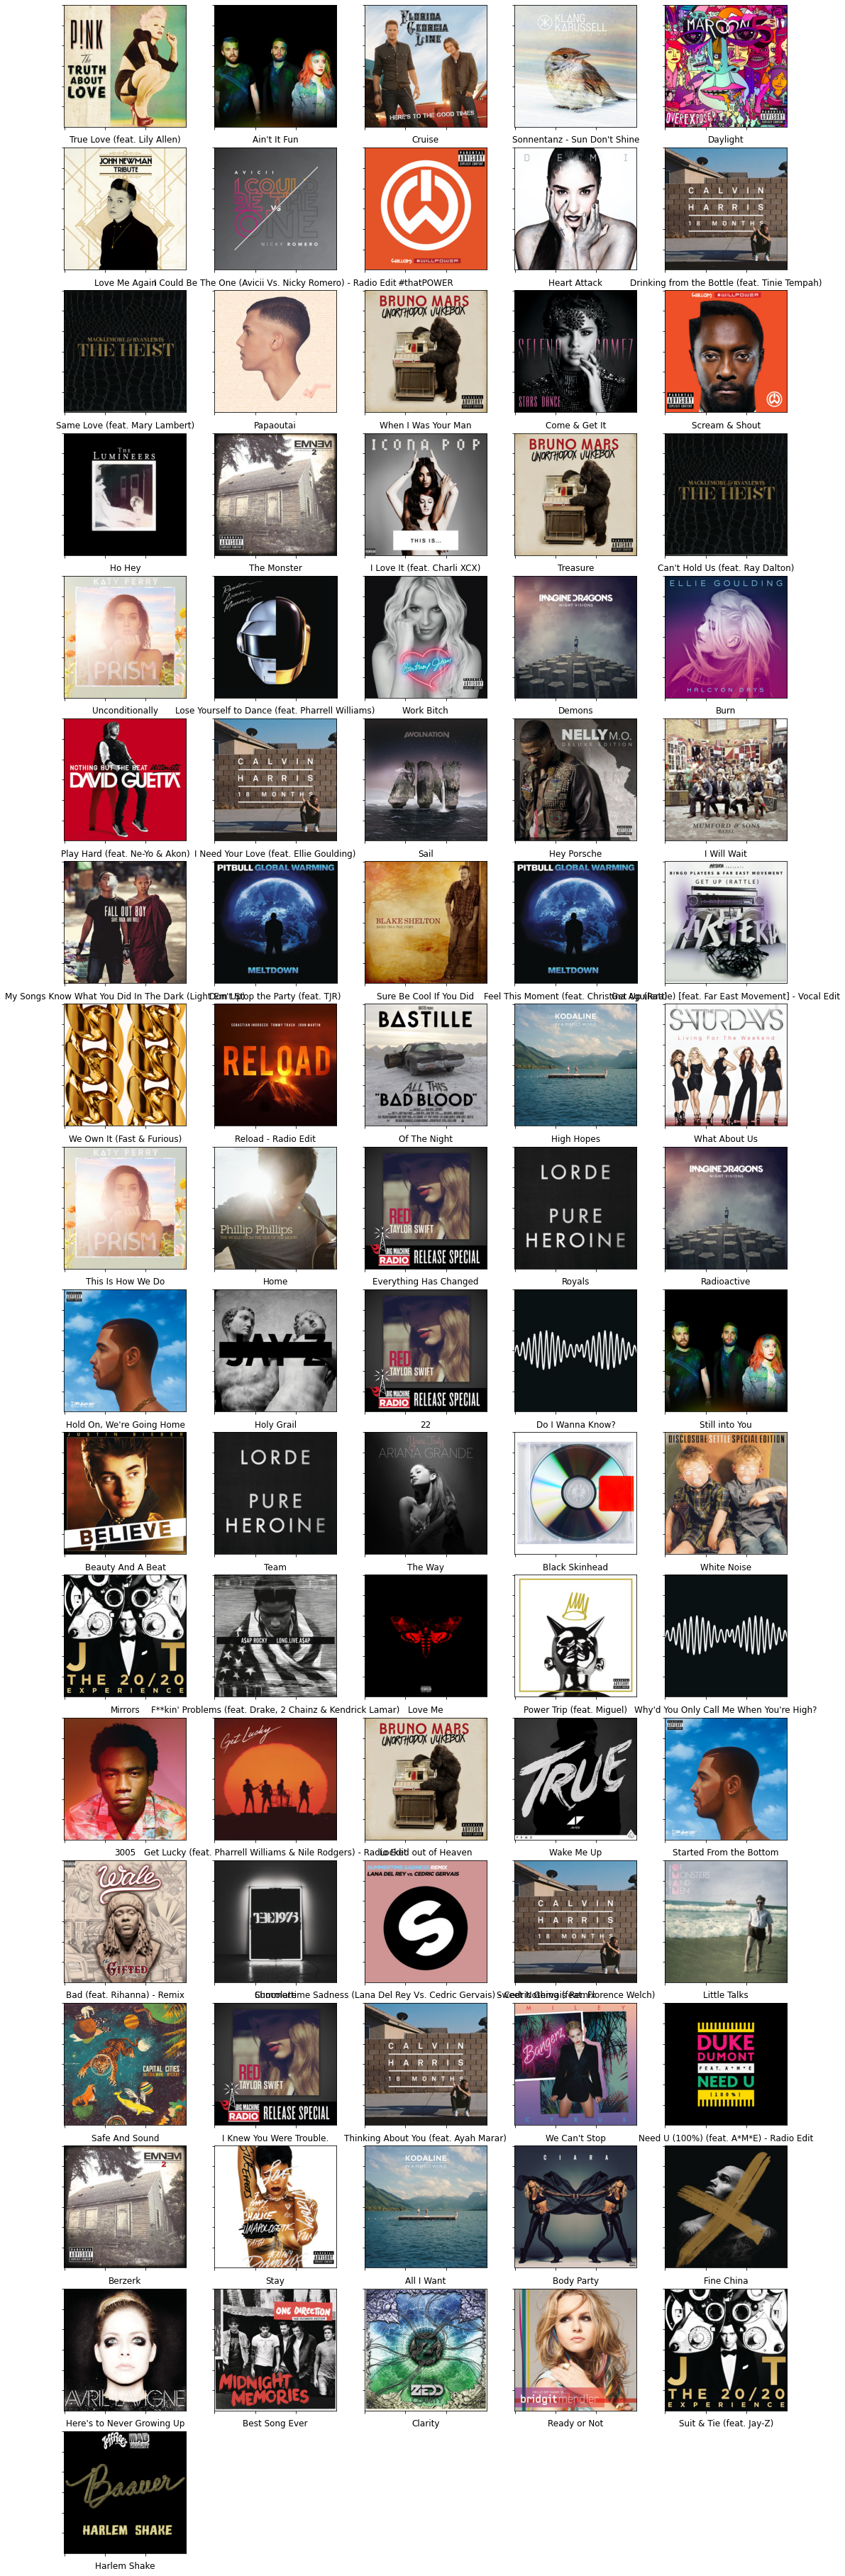

In [66]:
visualize_songs(playlist_Chill_Mix)

In [67]:
def generate_playlist_feature(complete_feature_set, playlist_df, weight_factor):
    """ 
    Summarize a user's playlist into a single vector

    Parameters: 
        complete_feature_set (pandas dataframe): Dataframe which includes all of the features for the spotify songs
        playlist_df (pandas dataframe): playlist dataframe
        weight_factor (float): float value that represents the recency bias. The larger the recency bias, the most priority recent songs get. Value should be close to 1. 
        
    Returns: 
        playlist_feature_set_weighted_final (pandas series): single feature that summarizes the playlist
        complete_feature_set_nonplaylist (pandas dataframe): 
    """
    
    complete_feature_set_playlist = complete_feature_set[complete_feature_set['id'].isin(playlist_df['id'].values)]#.drop('id', axis = 1).mean(axis =0)
    complete_feature_set_playlist = complete_feature_set_playlist.merge(playlist_df[['id','date_added']], on = 'id', how = 'inner')
    complete_feature_set_nonplaylist = complete_feature_set[~complete_feature_set['id'].isin(playlist_df['id'].values)]#.drop('id', axis = 1)
    
    playlist_feature_set = complete_feature_set_playlist.sort_values('date_added',ascending=False)

    most_recent_date = playlist_feature_set.iloc[0,-1]
    
    for ix, row in playlist_feature_set.iterrows():
        playlist_feature_set.loc[ix,'months_from_recent'] = int((most_recent_date.to_pydatetime() - row.iloc[-1].to_pydatetime()).days / 30)
        
    playlist_feature_set['weight'] = playlist_feature_set['months_from_recent'].apply(lambda x: weight_factor ** (-x))
    
    playlist_feature_set_weighted = playlist_feature_set.copy()
    #print(playlist_feature_set_weighted.iloc[:,:-4].columns)
    playlist_feature_set_weighted.update(playlist_feature_set_weighted.iloc[:,:-4].mul(playlist_feature_set_weighted.weight,0))
    playlist_feature_set_weighted_final = playlist_feature_set_weighted.iloc[:, :-4]
    #playlist_feature_set_weighted_final['id'] = playlist_feature_set['id']
    
    return playlist_feature_set_weighted_final.sum(axis = 0), complete_feature_set_nonplaylist

In [68]:
complete_feature_set_playlist_vector_Chill_Mix, complete_feature_set_nonplaylist_Chill_Mix  = generate_playlist_feature(final, playlist_Chill_Mix, 1.09)

In [69]:
complete_feature_set_playlist_vector_Chill_Mix.shape

(116,)

## Generate Recommendations

In [70]:
def generate_playlist_recos(df, features, nonplaylist_features):
    """ 
    Pull songs from a specific playlist.

    Parameters: 
        df (pandas dataframe): spotify dataframe
        features (pandas series): summarized playlist feature
        nonplaylist_features (pandas dataframe): feature set of songs that are not in the selected playlist
        
    Returns: 
        non_playlist_df_top_40: Top 40 recommendations for that playlist
    """
    
    non_playlist_df = df[df['id'].isin(nonplaylist_features['id'].values)]
    non_playlist_df['sim'] = cosine_similarity(nonplaylist_features.drop('id', axis = 1).values, features.values.reshape(1, -1))[:,0]
    non_playlist_df_top_40 = non_playlist_df.sort_values('sim',ascending = False).head(40)
    non_playlist_df_top_40['url'] = non_playlist_df_top_40['id'].apply(lambda x: sp.track(x)['album']['images'][1]['url'])
    
    return non_playlist_df_top_40

In [71]:
top40 = generate_playlist_recos(tracks_df, complete_feature_set_playlist_vector_Chill_Mix, complete_feature_set_nonplaylist_Chill_Mix)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [72]:
top40

id  \
131595  6i8w8Zdud22ehgJrrzqIVi   
86408   2Kspa0jD2MSkaEdonf4Cnb   
121082  2BNuFV7ROaRHu2j3N6k729   
86792   18e3XXYCv4Tx8uUl1mP3CN   
86952   3n3S5cH3IyaOswY2XSUGTS   
86396   3uvypVUsiIr1B0BccIcsEh   
86612   6WuufZDBNoEJBTinRiznhO   
118287  0wLqXnCLseMice1Hwq6yLz   
86291   3tCwjWLicbjsMCvXhN0WOE   
86776   6LsUo3PX3QeJmWBRcmaf5b   
131523  3qM75mSV84LHHJqlITqZsk   
86985   60b6B2ULC85t4Y5IjZvP7A   
86808   1vELwZM3uBYWd8HrtddD4l   
86462   0O3TAouZE4vL9dM5SyxgvH   
121142  1Acgi7wxVD9OF3iQnFe8Q4   
118285  6bRkTmvWjUr6aCXrKGIaG5   
86342   2rzBvHM9h36Tpdj7Jdajka   
131546  4EwNWRBWdZ6bgvxRHlZ8OO   
86728   3aGJClg6klBoSa0UZnXeMM   
86486   0bdL8X3MrX51dRz231BFtv   
86460   5e3UWcbvTaF5CJWu81MqlQ   
86874   62x93blgkWEz6Huop8eSQA   
86372   6a0G8hYEyxqvEkebVLU5VK   
131593  3Wn52FjoUJClQOXwKePPp3   
86450   1cSXzDZt8vzuUp2XREQEJN   
86702   5JUufCEin0aXyFLXCzJbUL   
86440   7corSqnjU5bX09ZXy3nhVD   
121159  573latfTMO7SpGtStVrQx5   
86454   4LjfIjS8iweFCPdKxLnEoV   
86394   2wEjPgOCEczmjlvq60LyQi   
121102  51DZ0wUocQ8sQfjnibXVcD   
86163   5ka2ajep9OAvU5Sgduhiex   
86574   5HOpkTTVcmZHnthgyxrIL8   
304086  0Nk7bSn0MItonkR0GNs3mj   
131525  0zewUY3RSh8yaV7q66Okem   
86284   6twW4ma6w0mOeejejPK0nY   
86201   5vTPxzm4h2bY9rYyVrGEU5   
86908   1Tditr5KyzStSK3GiO6Xlj   
86706   1pKmfhwbZvsyYUP2eOGdw5   
322869  0LDT8QEHbPA0aawzm9CWP7   

                                                     name  popularity  \
131595  Can You Hear Me? (ayayaya) (feat. Skepta, JME ...          60   
86408                             We Are Bulletproof Pt.2          67   
121082                                  Attack on Bangtan          62   
86792                                      Balam Pichkari          63   
86952                                               Venus          62   
86396                                                6 AM          67   
86612                                    La Nueva Y La Ex          65   
118287                                  Si No Te Quisiera          64   
86291                                                Rude          69   
86776                                         Tocarte Toa          63   
131523                             Ein Affe und ein Pferd          61   
86985                                              Tamale          62   
86808                                               Bella          63   
86462                                       Fashion Killa          67   
121142                                           Don't Go          61   
118285                              La Hummer Y El Camaro          65   
86342   Wild for the Night (feat. Skrillex & Birdy Nam...          68   
131546                                            CROOKED          60   
86728                                       Does He Know?          64   
86486               Moviendo Caderas (feat. Daddy Yankee)          66   
86460   Cruisin' for a Bruisin' - From "Teen Beach Movie"          67   
86874                                       Band Plays On          62   
86372                                             しかばねの踊り          68   
131593                           It's Over When It's Over          60   
86450                             Atemlos durch die Nacht          67   
86702                                    Fashionably Late          64   
86440                                             君はできない子          67   
121159                                             Harlem          61   
86454                               Let Me Think About It          67   
86394                                Girls / Girls / Boys          67   
121102                                        Unbelievers          61   
86163                                            Applause          73   
86574                    The Fox (What Does the Fox Say?)          65   
304086                                         The Walker          62   
131525                                       Vegas Lights          61   
86284

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: Glyph 12375 (\N{HIRAGANA LETTER SI}) missing from current font.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: Glyph 12363 (\N{HIRAGANA LETTER KA}) missing from current font.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: Glyph 12400 (\N{HIRAGANA LETTER BA}) missing from current font.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: Glyph 12397 (\N{HIRAGANA LETTER NE}) missing from current font.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: Glyph 12398 (\N{HIRAGANA LETTER NO}) missing from current font.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: Glyph 36362 (\N{CJK UNIFIED IDEOGRAPH-8E0A}) missing from current font.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: Glyph 12426 (\N{HIRAGANA LETTER RI}) missing from current font

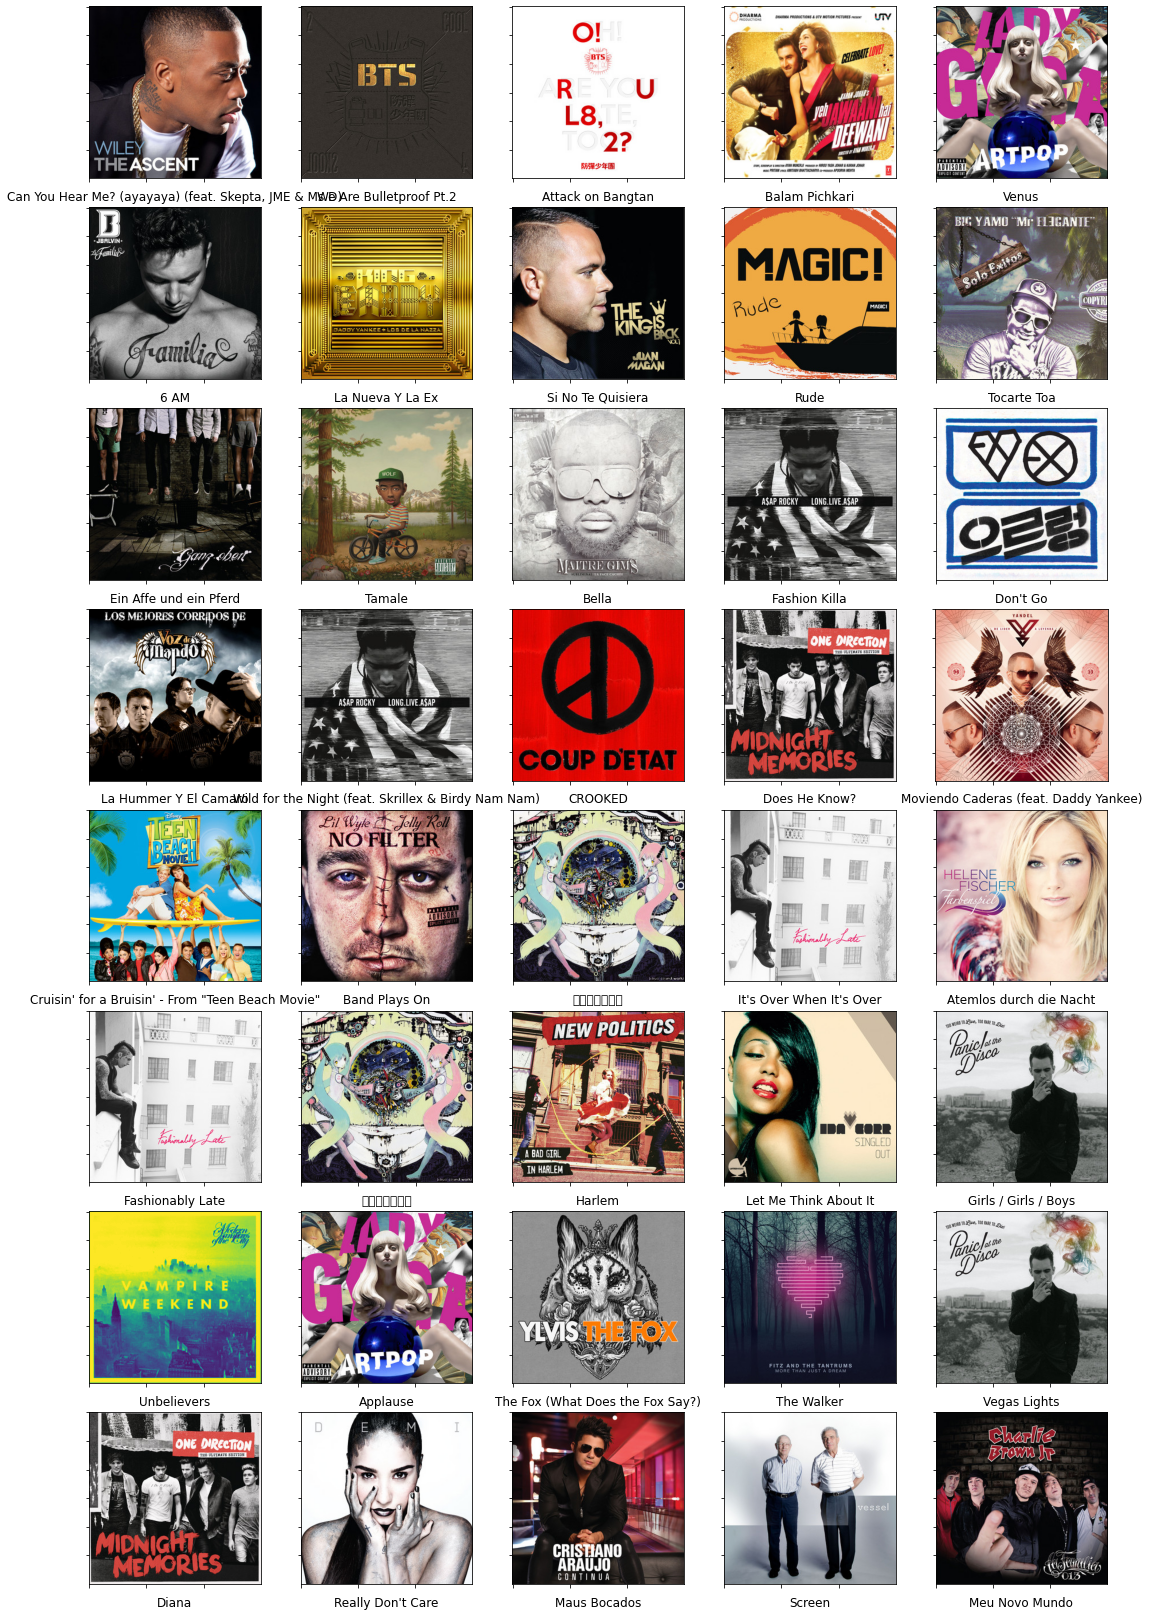

In [73]:
visualize_songs(top40)